# bm25 -- page #80, #86, and #87

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import sparse
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from ordered_set import OrderedSet
from nltk.corpus import stopwords
import string
import re


In [19]:
def get_and_clean_data():
    data = pd.read_csv('../resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' '*len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

def create_stem_cache(cleaned_description): 
 tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s)) 
 concated = np.unique(np.concatenate([s for s in tokenized_description.values])) 
 stem_cache = {} 
 ps = PorterStemmer() 
 for s in concated: 
    stem_cache[s] = ps.stem(s) 
 return stem_cache
  
def create_custom_preprocessor(stop_dict, stem_cache): 
    def custom_preprocessor(s): 
        ps = PorterStemmer() 
        s = re.sub(r'[^A-Za-z]', ' ', s) 
        s = re.sub(r'\s+', ' ', s) 
        s = word_tokenize(s) 
        s = list(OrderedSet(s) - stop_dict) 
        s = [word for word in s if len(word)>2] 
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s] 
        s = ' '.join(s) 
        return s 
    return custom_preprocessor

def sk_vectorize(texts, cleaned_description, stop_dict, stem_cache): 
    my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache) 
    vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor) 
    vectorizer.fit(cleaned_description) 
    query = vectorizer.transform(texts) 
    print(query) 
    print(vectorizer.inverse_transform(query))

In [20]:
class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """ Fit IDF to documents X """
        self.vectorizer.fit(X) 
        self.y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = self.y.sum(1).mean()

    def transform(self, q):
        """ Calculate BM25 between query q and documents X """
        b, k1, avdl = self.b, self.k1, self.avdl

         # apply CountVectorizer
        len_y = self.y.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = y.multiply(np.broadcast_to(idf, y.shape)) * (k1 + 1)
        return (numer / denom).sum(1).A1

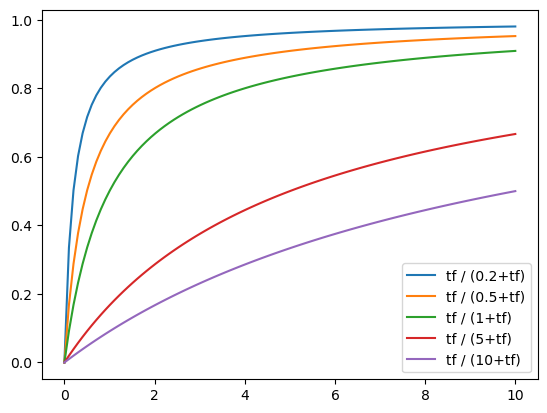

In [21]:
tf = np.linspace(0, 10, 100)
for k in [0.2, 0.5, 1, 5, 10]:
    plt.plot(tf, tf / (k+tf), label="tf / ("+str(k)+"+tf)")
plt.legend()
plt.show()

In [22]:
cleaned_description = get_and_clean_data()
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words('English')) 
my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)

In [24]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=my_custom_preprocessor, use_idf=True) 
tf_idf_vectorizer.fit(cleaned_description) 

bm25 = BM25(tf_idf_vectorizer)
bm25.fit(cleaned_description)
score = bm25.transform('aws devops')
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())
score = bm25.transform('aws github')
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())

|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [25]:
score = bm25.transform('aws github')
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())

|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                